# PROGRESS
- try to make it faster. many functions run multiple times for no reason

1. Imports Versioning

In [1]:
import gymnasium as gym
import matplotlib
import torch
import torchvision
import torchaudio
import pyautogui
import numpy as np

from collections import deque

print(gym.__version__)          # 0.29.1
print(matplotlib.__version__)   # 3.9.2
print(torch.__version__)        # 2.4.1+cpu
print(torchvision.__version__)  # 0.19.1+cpu
print(torchaudio.__version__)   # 2.4.1+cpu
print(pyautogui.__version__)    # 0.9.54
print(np.__version__)           # 1.26.4

0.29.1
3.9.2
2.4.1+cpu
0.19.1+cpu
2.4.1+cpu
0.9.54
1.26.4


2. Preprocessing Function

In [2]:
from torchvision import transforms

# Preprocess the frames (resize and convert to grayscale)
def preprocess_frame(frame):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(),  # Convert to grayscale
        transforms.Resize((84, 84)),  # Resize to 84x84
        transforms.ToTensor(),  # Convert to tensor, will have shape [1, 84, 84]
    ])
    return transform(frame).squeeze(0)  # Remove the single channel dimension, resulting in [84, 84]


# Stack 4 frames
def stack_frames(frames):
    return np.stack(frames, axis=0)  # Shape will be [4, 84, 84]


3. Initialise Environment, Model & Agent

In [3]:
from DQNCNN import DQNCNN
from DQNAgent import DQNAgent
from WASDEnv import WinFormsGameEnv

env = WinFormsGameEnv()

STACK_SIZE = 1 # amount of frames stacked
ACTION_SIZE = env.action_space.n

deep_q_learning_model = DQNCNN(action_size=ACTION_SIZE, stack_size=STACK_SIZE)
agent = DQNAgent(DQNCNN=deep_q_learning_model, action_size=ACTION_SIZE)
env.action_space.n

4

4. Training Loop

In [4]:
# Stack size for CNN input (4 stacked frames)
stack_size = 1

saved_frame = None

# Training loop
num_episodes = 1
for e in range(num_episodes):
    state_stack = deque(maxlen=stack_size)
    state = env.reset()
    
    # Initialize frame stack with initial frame
    frame = preprocess_frame(env.render())
    for _ in range(stack_size):
        state_stack.append(frame)


    saved_frame = frame

    done = False
    total_reward = 0
    while not done:
        state = stack_frames(state_stack)
        saved_frame = state
        # Choose an action
        action = agent.select_action(state)
        
        # Perform action
        next_state, reward, done, _, _ = env.step(action)
        
        # Process next state (frame) and add to the stack
        next_frame = preprocess_frame(env.render())
        state_stack.append(next_frame)
        next_state_stack = stack_frames(state_stack)

        # Store experience in replay memory
        agent.memory.add((state, action, reward, next_state_stack, done))
        
        # Train the agent with experience replay
        agent.replay()

        # Update the state
        state_stack = state_stack

        total_reward += reward
        
        # Periodically update target network
        if e % agent.update_frequency == 0:
            agent.update_target_network()

    print(f"Episode: {e+1}/{num_episodes}, Total Reward: {total_reward}")

env.close()


Episode: 1/1, Total Reward: 0


5. Save Model Weights

In [243]:
import torch

# Assuming `agent` is your trained model and `path_to_save` is the file path
torch.save(agent.q_network.state_dict(), './q_network_WASD.pth')
torch.save(agent.target_network.state_dict(), './target_network_WASD.pth')

6. Load Model Weights

In [5]:
import torch

# Assuming `Agent` is your model class
agent.q_network = DQNCNN(action_size=ACTION_SIZE, stack_size=STACK_SIZE)  # Initialize the model architecture
agent.q_network.load_state_dict(torch.load('./model/q_network_WASD_perfect.pth'))

agent.target_network = DQNCNN(action_size=ACTION_SIZE, stack_size=STACK_SIZE)  # Initialize the model architecture
agent.target_network.load_state_dict(torch.load('./model/target_network_WASD_perfect.pth'))

# Ensure the models are in evaluation mode
agent.q_network.eval()
agent.target_network.eval()


C:\Users\Kaan\AppData\Local\Temp\ipykernel_16432\50916430.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.q_network.load_state_dict(torch.load('./model/q_network_W

DQNCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

7. Test Model

In [6]:
import matplotlib.pyplot as plt 
import time

# Testing loop (after training)
num_test_episodes = 1
stack_size = 1
all_rewards = 0
MAX_SCORE= 100

for e in range(num_test_episodes):
    start_time = time.time() # start timer
    state_stack = deque(maxlen=stack_size) # create stack for frames
    state = env.reset() # get initial state
    frame = preprocess_frame(state) # preprocess state/frame
    for _ in range(stack_size): # fill frames
        state_stack.append(frame)

    done = False
    total_reward = 0

    while not done:
        state = stack_frames(state_stack)

        # Use the trained model to select an action (no exploration during testing)
        action = agent.select_action(state, explore=False)  # No exploration in testing

        # Perform the action in the environment
        next_state, reward, done, _, _ = env.step(action)

        # Process the next state (frame) and update the frame stack
        next_frame = preprocess_frame(env.render())
        state_stack.append(next_frame)

        total_reward += reward

        # Update the plot with the new frame
        # plt.title(f"Test Episode: {e + 1}/{num_test_episodes}, Total Reward: {total_reward}")
        # plt.pause(0.001)  # Short pause to allow plot to update
        if total_reward == MAX_SCORE:
            break
    end_time = time.time()
        # Calculate total time and actions per second (APS)
    total_time = end_time - start_time
    aps = MAX_SCORE / total_time
    print(f"Actions per second (APS): {aps}")

    print(f"Test Episode: {e + 1}/{num_test_episodes}, Total Reward: {total_reward}")
    all_rewards += total_reward
print(f'avg score: {all_rewards/num_test_episodes}')
env.close()


Actions per second (APS): 3.8966567083366894
Test Episode: 1/1, Total Reward: 100
avg score: 100.0


8. Training Results


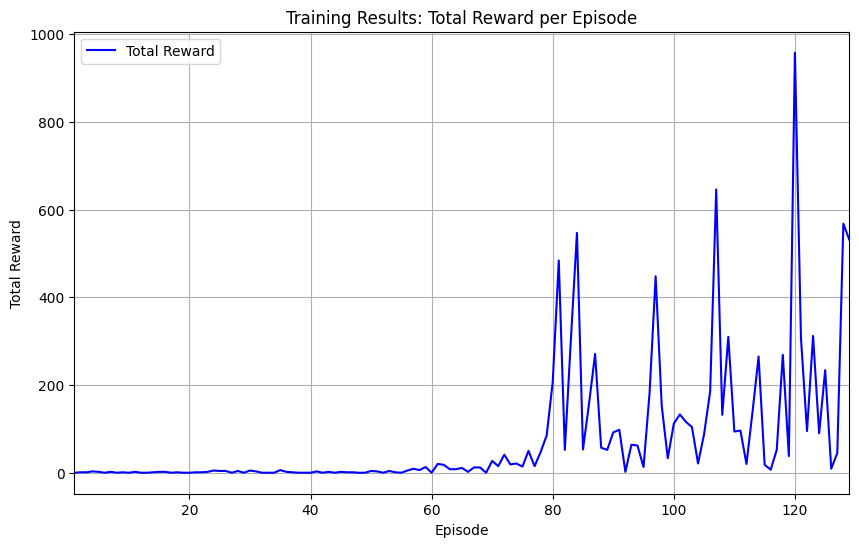

In [12]:
episodes = list(range(1, 130))
training_results = [
    0, 1, 1, 3, 2, 0, 2, 0, 1, 0, 2, 0, 0, 1, 2, 2, 0, 1, 0, 0, 1, 1, 2, 5, 4, 4, 0, 4, 0, 5, 
    3, 0, 0, 0, 6, 2, 1, 0, 0, 0, 3, 0, 2, 0, 2, 1, 1, 0, 0, 4, 3, 0, 4, 1, 0, 5, 9, 6, 13, 0, 
    20, 18, 8, 8, 11, 2, 12, 12, 0, 27, 15, 41, 19, 21, 14, 50, 15, 47, 85, 207, 484, 52, 304, 
    547, 53, 158, 271, 57, 52, 92, 98, 2, 64, 62, 13, 183, 448, 153, 33, 112, 133, 116, 104, 21, 
    88, 185, 646, 132, 310, 94, 96, 20, 139, 265, 18, 7, 52, 269, 38, 958, 307, 95, 312, 90, 234, 
    9, 45, 568, 531
]


# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(episodes, training_results, label="Total Reward", color="b")

plt.xlim([1, 129])

# Adding titles and labels
plt.title("Training Results: Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

9. Testing Results
- The testing results were never ending. I decided to stop it myself at a score of 20000

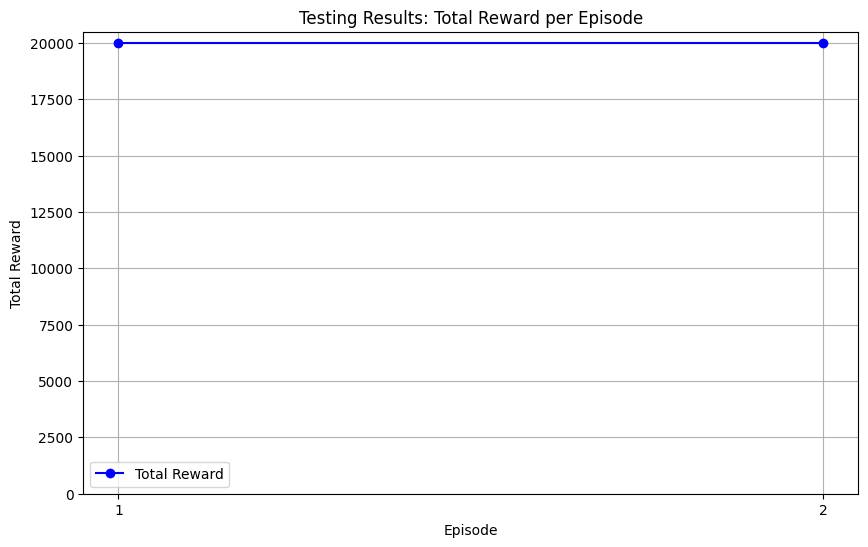

In [19]:
import matplotlib.pyplot as plt

# Define the episodes and testing results
episodes = [1, 2]
testing_results = [20000, 20000]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(episodes, testing_results, label="Total Reward", color="b", marker='o')

# Set the x-axis ticks with a step of 1.0
plt.xticks(range(min(episodes), max(episodes) + 1, 1))

# Set the y-axis limit slightly over 20000
plt.ylim([0, 20500])

# Adding titles and labels
plt.title("Testing Results: Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


Agent Speed: 3.8fps